> ### Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from iqual import nlpmodel, preprocessing, evaluation, crossval, tests

> ### Load datasets

In [3]:
data_dir         = "../data"

### Enhanced qualitative data
enhanced_data = pd.read_csv(os.path.join(data_dir,"enhanced_bootstrap_mean.csv"))

### Quantitative data
quant_df      = pd.read_csv(os.path.join(data_dir,"quant_data.csv"))

> ### Variables

In [4]:
annotation_vars = [
     "ability_high",
     "ability_low",
     "awareness_information_high",
     "awareness_information_low",
     "budget_high",
     "budget_low",
     "covid_impacts",
     "education_high",
     "education_low",
     "education_neutral",
     "education_religious",
     "entrepreneur",
     "job_secular",
     "marriage",
     "migration",
     "no_ambition",
     "public_assistance",
     "reliance_on_god",
     "religious",
     "secular",
     "vague_job",
     "vague_non_specific",
     "vocational_training",
     "worries_anxieties",
    ]

# TODO: Add Note to explain suffixes
human_annotation_vars = [c+"_act" for c in annotation_vars]

> ### Variables to Groupby

In [5]:
id_vars_human    = ['uid','data_round','refugee_status']
id_vars_enhanced = ['uid','data_round','refugee_status','bootstrap_run']

> ### Human Annotated Dataframe (Merged with quantiative data)

In [6]:
human_df = enhanced_data.loc[enhanced_data.annotated==1,[*id_vars_human,*human_annotation_vars]].copy()
human_df = human_df.rename(columns={c+"_act":c for c in annotation_vars}).drop_duplicates()
human_df = pd.merge(human_df,quant_df,on=['uid','data_round'],how='left')

human_df['sample_type'] = 'Human'

> ### Enhanced Dataframe (Merged with quantiative data)

In [7]:
enhanced_df = enhanced_data[[*id_vars_enhanced,*annotation_vars]].copy()
enhanced_df = pd.merge(enhanced_df,quant_df,on=['uid','data_round'],how='left')

enhanced_df['sample_type'] = 'Enhanced'

> ### HH characteristic variables for `Interpretability`

In [1]:
# Numerical regressors
numerical_vars = [
     'refugee',
     'hh_head_sex',
     'eld_sex',
     'parent_reledu',
     'data_round',
     'num_child',
     'hh_head_age',
     'parent_eduyears',
     'eld_age',
     'hh_asset_index',
     'hh_income',
     'int_trauma_exp',
]

### Interpretability tests on Human Data

In [2]:
interpreter = tests.Interpretability(human_df,
                                     annotation_vars=annotation_vars,
                                     numerical_regressors=numerical_vars,
                ).fit_all()

human_interp_df = interpreter.get_results()
human_interp_df['sample_type'] = 'Human'

human_interp_df.head(5)

NameError: name 'tests' is not defined

### Interpretability tests on Enhanced Data (Looping over Bootstrap runs)

In [10]:
enh_interp_dfs = []

bootstrap_runs = enhanced_df['bootstrap_run'].unique()

for b in bootstrap_runs:
    interpreter = tests.Interpretability(enhanced_df[enhanced_df['bootstrap_run']==b],
                                         annotation_vars=annotation_vars,
                                         numerical_regressors=numerical_vars,
                    ).fit_all()
    
    interp_df = interpreter.get_results()
    interp_df['bootstrap_run'] = b
    
    enh_interp_dfs.append(interp_df)
    
enhanced_interp_df = pd.concat(enh_interp_dfs)    
enhanced_interp_df['sample_type'] = 'Enhanced'

In [11]:
interpret_data = pd.concat([human_interp_df,enhanced_interp_df],axis=0)
interpret_data = interpret_data.sort_values('annotation',ascending=False,ignore_index=True)
interpret_data.head(5)

,annotation,fstat,log_fstat,pval,sample_type,bootstrap_run
0,worries_anxieties,10.363416,2.338282,3.566963e-20,Enhanced,9.0
1,worries_anxieties,12.714507,2.542744,1.602897e-25,Enhanced,17.0
2,worries_anxieties,9.621387,2.263988,1.715161e-18,Enhanced,20.0
3,worries_anxieties,5.024955,1.614417,4.787082e-08,Human,NaN
4,worries_anxieties,11.875976,2.474518,1.299716e-23,Enhanced,2.0


### Calculate Differences

In [12]:
enhanced_avg_df = enhanced_interp_df.groupby('annotation')['log_fstat'].mean().reset_index()
enhanced_avg_df['sample_type'] = 'Enhanced'

In [13]:
enhanced_avg_dict =  dict(enhanced_avg_df[['annotation','log_fstat']].values)
human_avg_dict    =  dict(human_interp_df[['annotation','log_fstat']].values)

### Visualize

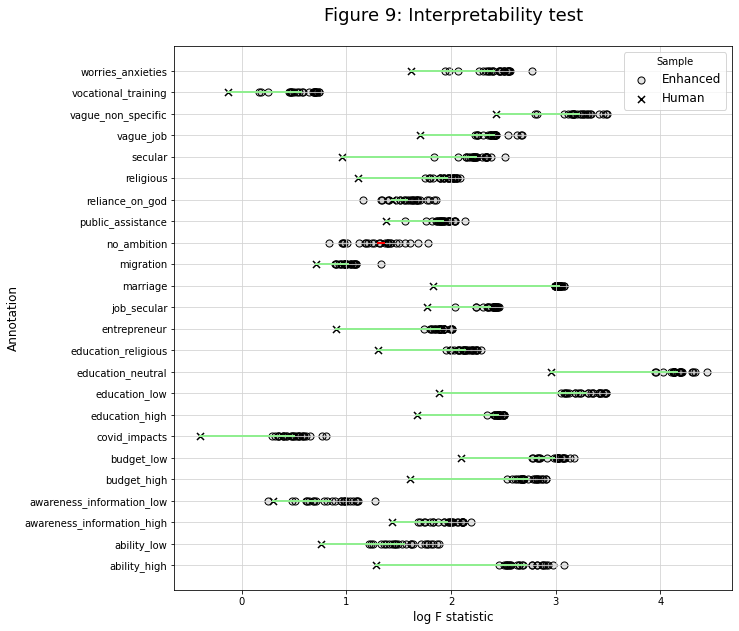

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

# Difference in F-statistic (Logarithmic) averages 
for annotation in annotation_vars:
    enh_value, human_value = enhanced_avg_dict[annotation], human_avg_dict[annotation]
    line_color = 'lightgreen' if enh_value >= human_value else 'red'
    ax.plot([enh_value, human_value], [annotation, annotation], color=line_color, linewidth=2)

# Enhanced Data Log F-statistic values for all bootstrap runs
enhanced_x = interpret_data.loc[interpret_data['sample_type'] == 'Enhanced', 'log_fstat'].tolist()
enhanced_y = interpret_data.loc[interpret_data['sample_type'] == 'Enhanced', 'annotation'].tolist()
ax.scatter(enhanced_x, enhanced_y, fc=(0,0,0, 0.1), marker='o', s=50, ec='k', lw=1, label='Enhanced')
    
# Human Data F-statistic (Logarithmic) values
human_x = interpret_data.loc[interpret_data['sample_type'] == 'Human', 'log_fstat'].tolist()
human_y = interpret_data.loc[interpret_data['sample_type'] == 'Human', 'annotation'].tolist()
ax.scatter(human_x, human_y, c='black', marker='x', s=50, label='Human',)

# Titles, Labels, Legends and formatting
ax.set_xlabel('log F statistic',fontsize=12)
ax.set_ylabel('Annotation', fontsize=12)
ax.legend(title='Sample',fontsize=12,loc='best')
ax.set_title('Figure 9: Interpretability test',fontsize=18, pad=25)
ax.grid(True, color='lightgray')
plt.show()